## Spatio-Temporal Aggregation of Landsat8 Data

### This notebook will animate the landsat data for 30 days.



**Author:** Arapaut V. Sivaprasad

**Date:** 25 March, 2020

In [37]:
##########################################################
# Author: Arapaut V. Sivaprasad.                         #
# Dates: Created: 17/02/2020; Last Modified: 25/03/2020  #
##########################################################

from owslib.wcs import WebCoverageService
from netCDF4 import Dataset
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.animation as animation
from IPython.display import HTML


In [38]:
# Create a 6D Numpy array to hold the tiles.
# 6 time stamps and 4x4 tiles of X, Y dimensions for 3 bands
tiles = np.zeros((6, 4, 4, 256, 256, 3))

#### Specify the GSKY capabilities end URL is below. It must be one that you can access. 

Normally there are several GSKY layers in the dataset. You must select one layer to view the data. By uncommenting its code you can display all available layers.

In [39]:
# Specify the GSKY production URL here. The layer is hard coded
gsky_url = 'https://gsky.nci.org.au/ows/dea'
layer = "landsat8_nbart_daily"
wcs = WebCoverageService(gsky_url, version='1.0.0')

# Uncomment below to see all layers.
# for layer in list(wcs.contents):
#    print ("Layer Name:", layer)
#    print ("Title:", wcs[layer].title, '\n')

In [40]:
tiles_list = [
    ['112.5,-21.94,123.75,-11.18',
    '123.75,-21.94,135.0,-11.18',
    '135.0,-21.94,146.25,-11.18',
    '146.25,-21.94,157.5,-11.18'],
    ['112.5,-31.95,123.75,-21.94',
    '123.75,-31.95,135.0,-21.94',
    '135.0,-31.95,146.25,-21.94',
    '146.25,-31.95,157.5,-21.94'],
    ['112.5,-40.98,123.75,-31.95',
    '123.75,-40.98,135.0,-31.95',
    '135.0,-40.98,146.25,-31.95',
    '146.25,-40.98,157.5,-31.95'],
    ['112.5,-48.92,123.75,-40.98',
    '123.75,-48.92,135.0,-40.98',
    '135.0,-48.92,146.25,-40.98',
    '146.25,-48.92,157.5,-40.98']    
]

Generating tiles. Dot = tile with data; Bar = empty tile. Will take up to a minute. Be patient!
.|...|...|..|||| 2020-02-03T00:00:00.000Z
|..||.|||.|||||| 2020-02-04T00:00:00.000Z
.....|...|.|||.| 2020-02-05T00:00:00.000Z
|..||..||.|||||| 2020-02-06T00:00:00.000Z
..|......|..||.| 2020-02-07T00:00:00.000Z
.|......|...||.. 2020-02-08T00:00:00.000Z

Finished! 96 tiles in 6 time slices


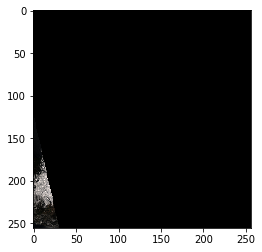

In [80]:
t = len(wcs[layer].timepositions) - 1
i = -1
ims = []
fig = plt.figure()
print("Generating tiles. Dot = tile with data; Bar = empty tile. Will take up to a minute. Be patient!")
for time in range(t-6, t):
    i += 1
    timeposition = wcs[layer].timepositions[time]
#     print("timeposition: ", timeposition)
    for j in range (0,4):
        for k in range (0,4):
            bbox = [tiles_list[j][k]]
            # Construct the URL for a WCS call and send it to the GSKY server.
            # Style can be False Color (fc) or True Color (tc)
            # This notebook uses only NetCDF and EPSG:4326. Hence, do not change these.
            # If any error, the displayed URL can be opened in a browser to see the actual error message.
            output = wcs.getCoverage(identifier=layer, Styles='tc',
                                     time=[timeposition],
                                     bbox=bbox,format='NetCDF',
                                     crs='EPSG:4326', width=256, height=256)

#             print(output.geturl())
            # Read the output into diskless NetCDF
            nc = Dataset('dtemp.nc','r',diskless=True,persist=False, memory=output.read())

            red = nc.variables['Band1'][:]
            try:
                green = nc.variables['Band2'][:]
            except:
                print("|", end='')
                rgb = np.stack([red, red, red], axis=2).astype(np.float32)
                rgb /= rgb.max()
                tiles[i,j,k] = rgb
                ims.append([plt.imshow(rgb, animated=True)])
                continue
            blue = nc.variables['Band3'][:]
            # Stack the three bands together and cast it as float32
            # In the line below the 'axis=2' ensures that the data shape is 256,256,3
            rgb = np.stack([red, green, blue], axis=2).astype(np.float32)
            # Convert all values into a range from 0 to 1. This is important.
            rgb /= rgb.max()
            tiles[i,j,k] = rgb

            # Plot it
            print(".", end='')
            ims.append([plt.imshow(rgb, animated=True)])
#             plt.show()
    print("", timeposition)
            
print("\nFinished! {} tiles in {} time slices".format(len(ims), i+1))


In [81]:
animate = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=4000)
plt.show()
HTML(animate.to_jshtml())

`Copyright` &copy; `2019 by National Computational Infrastructure (NCI).`